## ADVANCED MODELLING WITH XGBOOST Modeling

This notebook applies a tuned XGBoost classifier to predict passenger survival on the Titanic. It builds on previous models (Logistic Regression, Random Forest) and incorporates hyperparameter tuning, evaluation, and model explainability using SHAP.

In [1]:
# IMPORTING IMPORTANT REQUIRED TOOLS


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Modeling
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Pipeline tools
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Saving our model
import joblib

# For styling
sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("/Users/joshndirangu/Documents/titanic-eda/data/engineered_titanic.csv")

In [24]:
y = df['Survived']
X = df.drop(['PassengerId','Survived', 'SibSp', 'Parch', 'Fare', 'Age'], axis=1)

# Confirming the shape
print(X.shape)

print(y.shape)

(891, 8)
(891,)


### Spliting Our Data Into Training and Test Sets

In [25]:
from sklearn.model_selection import train_test_split

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% for testing, 80 FOR TRAINING
    random_state=42,         # same split whenever you run
    stratify=y               # maintains the class distribution in both sets
)

# Confirm shapes
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

# Check target distribution in both sets
print("Training set class balance:\n", y_train.value_counts(normalize=True))
print("Test set class balance:\n", y_test.value_counts(normalize=True))

X_train shape: (712, 8)
X_test shape : (179, 8)
y_train shape: (712,)
y_test shape : (179,)
Training set class balance:
 Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Test set class balance:
 Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


### XGBoost Model Training

In [26]:
# Importing the libraries required 

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Build pipeline
xgb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [27]:
# Training The Model 

xgb_pipeline.fit(X_train, y_train)
print("Model training complete.")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:30:35] WARNING: /private/var/folders/xz/w2xjxjwd0n9bhv2r41r2rs4c0000gn/T/pip-install-9pjui4g5/xgboost_ff868fc42758426089a7caed5292100e/cpp_src/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.


In [28]:
# Testing The Model

y_pred = xgb_pipeline.predict(X_test)
y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]  # For ROC AUC


Accuracy: 0.7821229050279329

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       110
           1       0.75      0.65      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.78      0.78      0.78       179



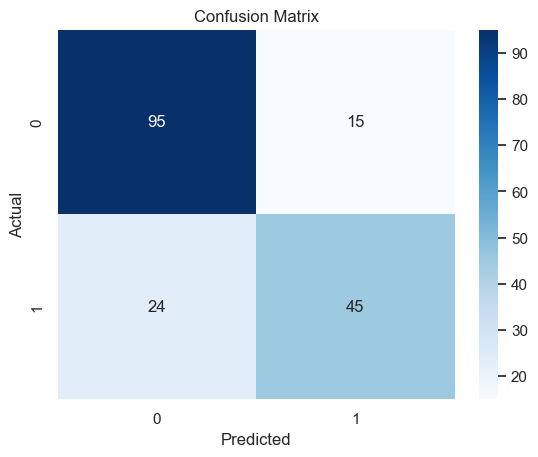

XGBoost ROC AUC Score: 0.8304


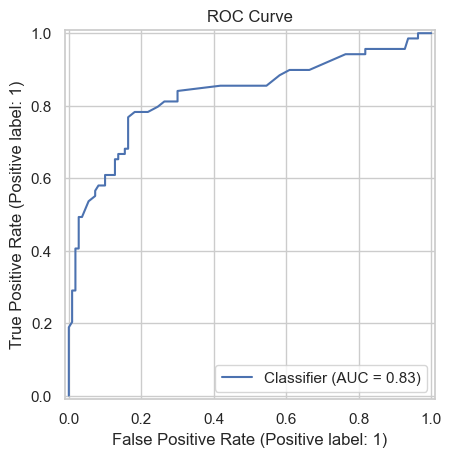

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# Saving our plot: 
plt.savefig("/Users/joshndirangu/Documents/titanic-eda/images/modeling/xgboost_confusion-matrix.png", dpi=300)

plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"XGBoost ROC AUC Score: {roc_auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
# Saving our plot: 
plt.savefig("/Users/joshndirangu/Documents/titanic-eda/images/modeling/xgboost_ROC-curve.png", dpi=300)

plt.show()

In [9]:
# Saving our trained model

joblib.dump(xgb_pipeline, "/Users/joshndirangu/Documents/titanic-eda/models/xgboost_pipeline.pkl")
print("Model saved to models/xgboost_pipeline.pkl")


Model saved to models/xgboost_pipeline.pkl


### HyperParameter Tuning

In [10]:
# Importing required tools

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


In [11]:
# Defining hyperparameter space. We also use xgb to match the name of the pipeline

param_distributions = {
    "xgb__n_estimators": randint(100, 1000),
    "xgb__max_depth": randint(3, 10),
    "xgb__learning_rate": uniform(0.01, 0.3),
    "xgb__subsample": uniform(0.6, 0.4),        # values from 0.6 to 1.0
    "xgb__colsample_bytree": uniform(0.6, 0.4), # values from 0.6 to 1.0
    "xgb__gamma": uniform(0, 0.5),
    "xgb__min_child_weight": randint(1, 10)
}


In [12]:
# Initializing randomized search

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=50,                     # Number of random combinations to try
    scoring='roc_auc',
    cv=5,                          # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1                      # Using all the cores
)


In [13]:
# Running the search

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*use_label_encoder.*")

random_search.fit(X_train, y_train)
print("Hyperparameter tuning complete.")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:41:49] WARNING: /private/var/folders/xz/w2xjxjwd0n9bhv2r41r2rs4c0000gn/T/pip-install-9pjui4g5/xgboost_ff868fc42758426089a7caed5292100e/cpp_src/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:41:49] WARNING: /private/var/folders/xz/w2xjxjwd0n9bhv2r41r2rs4c0000gn/T/pip-install-9pjui4g5/xgboost_ff868fc42758426089a7caed5292100e/cpp_src/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:41:49] WARNING: /private/var/folders/xz/w2xjxjwd0n9bhv2r41r2rs4c0000gn/T/pip-install-9pjui4g5/xgboost_ff868fc4275842

Hyperparameter tuning complete.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:42:18] WARNING: /private/var/folders/xz/w2xjxjwd0n9bhv2r41r2rs4c0000gn/T/pip-install-9pjui4g5/xgboost_ff868fc42758426089a7caed5292100e/cpp_src/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
# Reviewing the best parameters and score
print("Best parameters found:")
print(random_search.best_params_)

print("\nBest ROC AUC score on training set:")
print(random_search.best_score_)


Best parameters found:
{'xgb__colsample_bytree': 0.9022204554172195, 'xgb__gamma': 0.11439908274581123, 'xgb__learning_rate': 0.0330939729486379, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 185, 'xgb__subsample': 0.9521871356061031}

Best ROC AUC score on training set:
0.879254153341144


In [33]:
# Evaluating the best model on Test Set

# Predict on test set using best estimator
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC Score: {roc_auc:.4f}")


Accuracy: 0.7988826815642458

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179

Test ROC AUC Score: 0.8598


In [16]:
# Saving our XGBOOST Model

joblib.dump(best_model, "/Users/joshndirangu/Documents/titanic-eda/models/xgboost_pipeline_tuned.pkl")
print("Tuned model saved to models/xgboost_pipeline_tuned.pkl")


Tuned model saved to models/xgboost_pipeline_tuned.pkl


In [17]:
# Getting the trained XGboost estimator 

xgb = best_model.named_steps["xgb"]


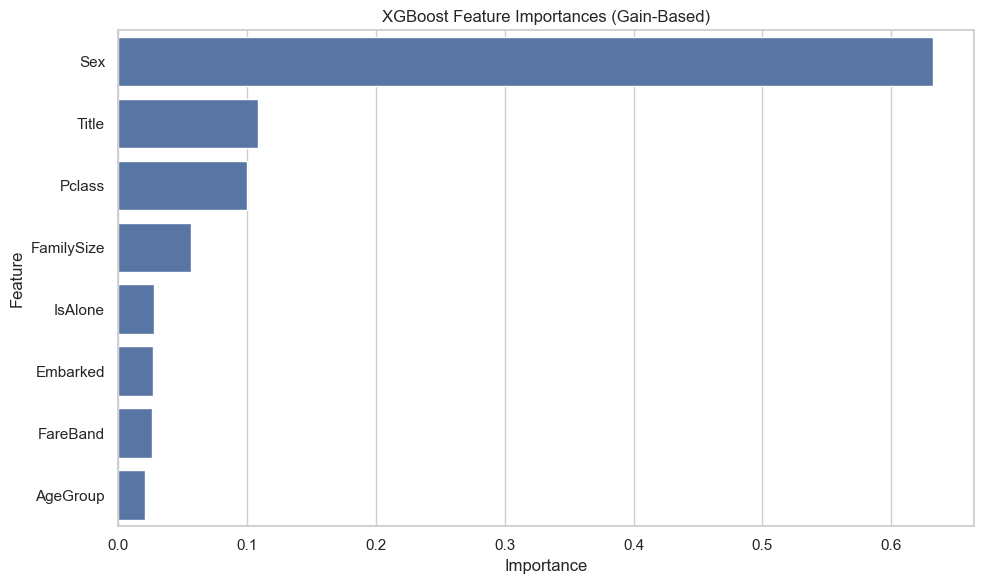

In [18]:
# Plotting feature Importances

feature_names = X_train.columns

# Getting importance scores
importance = xgb.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# Plotting...
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("XGBoost Feature Importances (Gain-Based)")
plt.tight_layout()
# Saving our plot: 
plt.savefig("/Users/joshndirangu/Documents/titanic-eda/images/modeling/xgboost_feature_importance.png", dpi=300)


plt.show()

In [19]:
# Importing shap and JS based visualiztions:
import shap
shap.initjs()


# Extracting the raw XGBoost model from pipeline
xgb_model = best_model.named_steps["xgb"]

# Initializing SHAP explainer, use training data only
explainer = shap.Explainer(xgb_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)


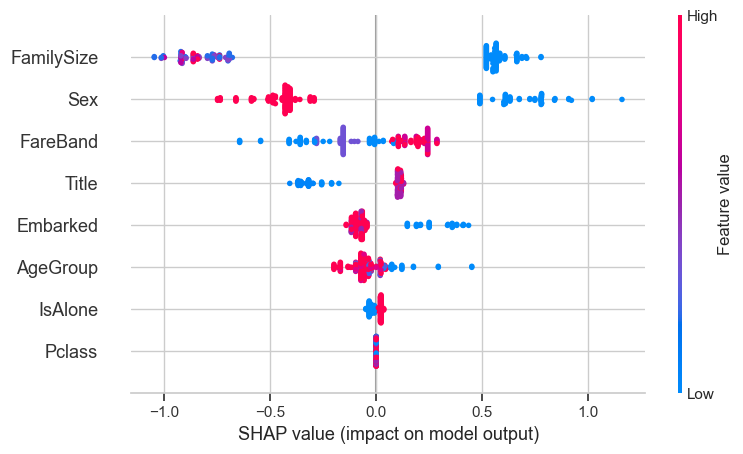

In [20]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("/Users/joshndirangu/Documents/titanic-eda/images/modeling/shap_summary_plot.png", dpi=300, bbox_inches='tight')

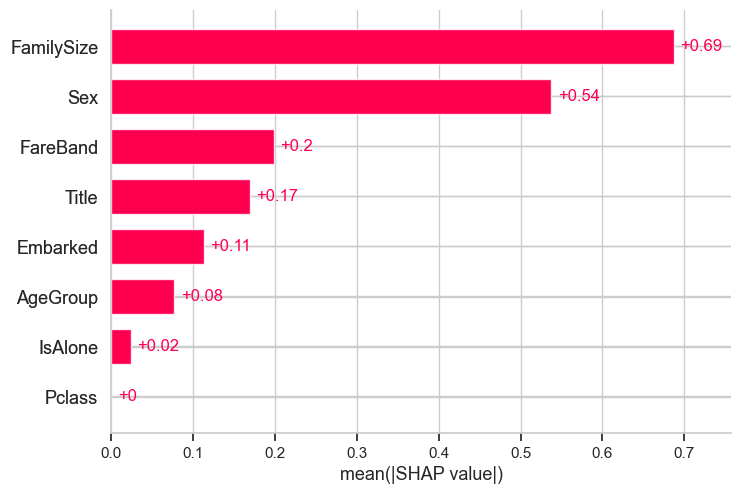

In [21]:
# SHAP Bar plot. Average feature importance
shap.plots.bar(shap_values, show=False)
plt.savefig("/Users/joshndirangu/Documents/titanic-eda/images/modeling/shap_bar_plot.png", dpi=300, bbox_inches='tight')

In [22]:
# SHAP plot,local explanation
shap.plots.force(shap_values[3])

In [23]:
# Saving the plot, local explanation. JS based visualization

force_plot = shap.plots.force(shap_values[3])
shap.save_html("/Users/joshndirangu/Documents/titanic-eda/images/modeling/force_plot_3.html", force_plot)

## Final Model Summary & Comparison

This notebook implemented a tuned **XGBoost Classifier** for predicting Titanic passenger survival. The model was evaluated against previous classifiers (Logistic Regression and Random Forest), and its performance was compared across multiple metrics.

### Final Model Performance (Test Set)

| Model                | Accuracy | F1-score (Survived) | ROC AUC |
|---------------------|----------|----------------------|---------|
| Logistic Regression | 0.8101   | 0.74                 | **0.8588**  |
| Random Forest       | **0.8324**  | **0.77**            | 0.8134  |
| XGBoost (Tuned)     | 0.80   | 0.72                 | 0.8304  |

### Observations

- **Random Forest** achieved the **highest accuracy and F1-score**, making it the best performer in terms of balanced classification.
- **Logistic Regression** delivered the **highest ROC AUC score**, meaning it was the best at distinguishing survivors from non-survivors across thresholds.
- **XGBoost**, while slightly behind on accuracy and F1-score, still produced a **strong ROC AUC score** and offered **rich explainability** through SHAP visualizations.
  
### Interpretability

- SHAP summary and force plots helped identify key features influencing the survival prediction, such as `Sex`, `Fare`, and `Pclass`.
- This adds valuable transparency to the model’s decision-making process.

### Model Saving

The tuned XGBoost pipeline was saved to:
``models/xgboost_pipeline_tuned.pkl``  
SHAP visualizations were saved to the ``images/`` directory for integration into the final report or app.

---

### Next Steps
- Integrate the model into a web app using Streamlit

